# Team 42 - Notebook - June 24

## Hackathon Challenges (Wednesday)

1. Calculate three relevant evaluation metrics for each ML solution and baseline
2. Refine machine learning approaches and test additional hyperparameter settings

We tested RMSE, R2 and Hellenger Distance for several ML models, and visualized the time series of concentrations for each chemical species. The time series seems spurious, and surprisingly, linear regression produces the best result. The reason why there is a spurious prediction will be investigated after the submission of this Notebook.

In [ ]:
%%capture
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

In [ ]:
%%capture
pip install --upgrade pandas

In [ ]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
%matplotlib inline

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam

In [ ]:
# Fix random state

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Functions defined in the original Notebook
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results


def run_emulator_ensemble(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_expiriments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

In [ ]:
# Functions modified for recurrent neural network models

def box_emulator2(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]


    for i in range(num_timesteps):

        if i == 0:
            scaled_input = np.reshape(scaled_input, (scaled_input.shape[0], 1, scaled_input.shape[1]))
            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            new_input = np.reshape(new_input, (new_input.shape[0], 1, new_input.shape[1]))
            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble2(input_data, mod, num_expiriments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_expiriments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_expiriments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator2(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

In [ ]:
# Load data

fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [ ]:
# Drop some unnecessary columns, and apply scalers

input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)
test_in, test_out = prepare_data(test, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])

scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

scaled_test_in = input_scaler.transform(test_in.iloc[:,1:-1])
scaled_test_out = output_scaler.transform(test_out.iloc[:,1:-1])

In [ ]:
scaled_train_in.shape

(2015999, 9)

In [ ]:
# Define some neural network models

def Model_Dense(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                num_input_columns=9, num_output_columns=3):
  input_layer = Input(num_input_columns)
  n_net = input_layer
  for i in range(num_layers):
    n_net = Dense(num_neurons, activation=activation)(n_net)
  out = Dense(num_output_columns)(n_net)
  model = Model(input_layer, out)
  model.compile(Adam(learning_rate=learning_rate), "mse")

  return model


def Model_cuDNN():

  model = Sequential()
  model.add(LSTM(128, activation="tanh", recurrent_activation="sigmoid",
                 recurrent_dropout=0, unroll=False, use_bias=True, input_shape=(1,9)))
  model.add(Dense(3))
  model.compile(Adam(learning_rate=0.001), "mse")

  return model


def Model_LSTM():

  activation = "softmax"
  recurrent_activation = "tanh"
  recurrent_dropout = 0.0

  model = Sequential()
  model.add(LSTM(64, activation=activation, recurrent_activation=recurrent_activation,
                recurrent_dropout=recurrent_dropout, input_shape=(1,9), return_sequences=True))
  model.add(LSTM(64, activation=activation, recurrent_activation=recurrent_activation,
                 recurrent_dropout=recurrent_dropout, return_sequences=True))
  model.add(LSTM(64, activation=activation, recurrent_activation=recurrent_activation))
  model.add(Dense(3))
  model.compile(Adam(learning_rate=0.001), "mse")

  return model

In [ ]:
# Models which reshaping is not required
# GridSearchCV will be applied to find the optimal hyperparameters for each model in the later version.
model_LinearRegression = LinearRegression()
model_Ridge = Ridge()
model_Lasso = Lasso(alpha=0.005)
model_ENet = ElasticNet(alpha=0.005)
model_KernelRidge = KernelRidge(alpha=0.05, kernel="polynomial", degree=2)
model_RandomForest = RandomForestRegressor(criterion="mse", bootstrap=True, n_estimators=200, max_depth=50, n_jobs=-1, verbose=1)
model_GradientBoost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=10, verbose=1)
model_Dense = Model_Dense()

# Models which reshaping is required
model_cuDNN = Model_cuDNN()
model_LSTM = Model_LSTM()

In [ ]:
X_train = np.copy(scaled_train_in)
y_train = np.copy(scaled_train_out)

X_validate = np.copy(scaled_val_in)
y_validate = np.copy(scaled_val_out)

X_test = np.copy(scaled_test_in)
y_test = np.copy(scaled_test_out)

In [ ]:
model_LinearRegression.fit(X_train, y_train)
model_Ridge.fit(X_train, y_train)
model_Lasso.fit(X_train, y_train)
model_ENet.fit(X_train, y_train)

ElasticNet(alpha=0.005)

In [ ]:
# It takes quite a time!
model_RandomForest.fit(X_train, y_train)

In [ ]:
# It takes quite a time!
model_GradientBoost.fit(X_train, y_train)

In [ ]:
tf.random.set_seed(seed)
model_Dense.summary()
history = model_Dense.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=256, epochs=5, verbose=1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1000      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 11,403
Trainable params: 11,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7875/7875 [==============================] - 18s 2ms/step - loss: 4.2988e-04 - val_loss: 3.1607e-04
Epoch 2/5
7875/7875 [==============================] - 18s 2ms/step - loss: 2.9030e-04 - val_loss: 2.8920e-04
Epoch 3/5
7875/7875 [============

Metrics for base model:
RMSE: Precursor: 0.00018, Gas: 0.00021, Aerosols: 0.00006
R2: Precursor: 0.99997, Gas: 0.99993, Aerosols: 0.99999
Hellenger Distance: Precursor: 0.00003, Gas: 0.00001, Aerosols: 0.00002

Metrics for Box Emulator:
RMSE: Precursor: 0.00375, Gas: 0.01818, Aerosols: 0.02049
R2: Precursor: 0.88393, Gas: 0.55147, Aerosols: 0.72645
Hellenger Distance: Precursor: 0.35322, Gas: 0.22406, Aerosols: 0.54450


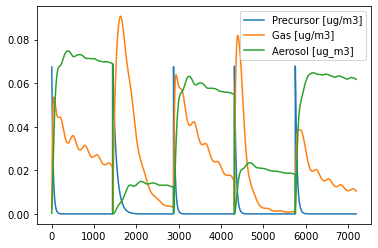

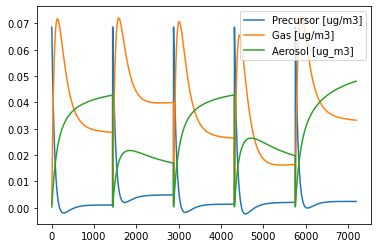

In [ ]:
# Linear Regression

random.seed(seed)
num_exps = 5
mod = model_LinearRegression

pred_box, true_box = run_emulator_ensemble(val_in, mod, num_exps, input_vars, input_scaler, output_scaler)

pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

print('\nMetrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

In [ ]:
# Dense Neural Network

random.seed(seed)
num_exps = 5
mod = model_Dense

pred_box, true_box = run_emulator_ensemble(val_in, mod, num_exps, input_vars, input_scaler, output_scaler)

pred_nn = pd.DataFrame(output_scaler.inverse_transform(mod.predict(scaled_val_in))).iloc[1:,:]
true_val = val_out.iloc[:-1,1:4]

print('Metrics for base model:')
evaluate_mod(true_val, pred_nn)

print('\nMetrics for Box Emulator:')
evaluate_mod(true_box, pred_box)

true_box.iloc[:,0:3].plot()
pred_box.iloc[:,0:3].plot()

In [ ]:
X_train = X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_validate = X_validate.reshape(X_validate.shape[0], 1, X_validate.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
tf.random.set_seed(seed)
model_cuDNN.summary()
history = model_cuDNN.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=256, epochs=5, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 387       
Total params: 71,043
Trainable params: 71,043
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7875/7875 [==============================] - 26s 3ms/step - loss: 7.1794e-04 - val_loss: 2.8673e-04
Epoch 2/5
7875/7875 [==============================] - 26s 3ms/step - loss: 2.8413e-04 - val_loss: 2.7580e-04
Epoch 3/5
7875/7875 [==============================] - 26s 3ms/step - loss: 2.8320e-04 - val_loss: 2.7868e-04
Epoch 4/5
7875/7875 [==============================] - 26s 3ms/step - loss: 2.8293e-04 - val_loss: 2.9148e-04
Epoch 5/5
7875/7875 [==============================] - 26s 3ms/step - lo

In [ ]:
tf.random.set_seed(seed)
model_LSTM.summary()
history = model_LSTM.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=256, epochs=5, verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 64)             18944     
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 195       
Total params: 85,187
Trainable params: 85,187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7875/7875 [==============================] - 93s 12ms/step - loss: 0.0140 - val_loss: 0.0011
Epoch 2/5
7875/7875 [==============================] - 92s 12ms/step - loss: 6.3065e-04 - val_loss: 2.8733e-04
Epoch 3/5
7875/7875 [=============